### Import Required Libraries
---

In [6]:
import os
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split

### Host or Colab Connection
---

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Debug
print(IN_COLAB)
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

False


In [3]:
if IN_COLAB:
  ds_path = '/content/drive/My Drive/projeto/dataset-article/dataset-64/'
else:
  ds_path = 'data/dataset-source/'

ds_path

'data/dataset-source/'

### Function to apply np zero to all normal label images
---

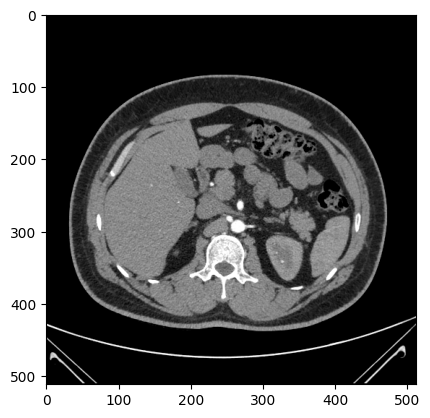

In [32]:
def np_zero_image():
    for i, image in enumerate(glob.glob(f"{ds_path}/normal/image/*jpg")):
      # read image in numpy array format
      img_normal = cv2.imread(image)
      
      # zero all pixels values image shape is (w, h, c)
      # convert image to black
      img_zeros = np.zeros(img_normal.shape)
      
      # define the path to write the image
      out_path = os.path.join(f"{ds_path}/normal/label/", f"{i+1}.jpg")
      cv2.imwrite(out_path,  img_zeros)
      
      plt.imshow(img_normal)
        
np_zero_image()

### Function to divide images into patches
- dataset-224
- dataset-96
- dataset-64

Shape of image patched:  (200, 350, 3)


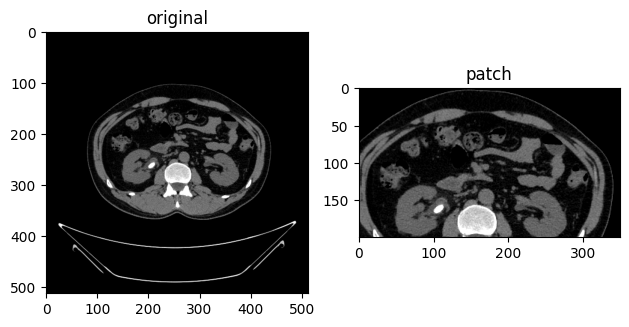

In [76]:
def images_patches(class_name, patch_size):
    fig, ax = plt.subplots(1, 2)
    
    for image in glob.glob(f"{ds_path}/{class_name}/image/*tif"):
      # read image in numpy array format
      img_normal = cv2.imread(image)
      img_patch = img_normal[100:300, 100:450] # image[y0:y1, x0:x1]
      
      print('Shape of image patched: ', img_patch.shape)
      ax[0].set_title('original')
      ax[0].imshow(img_normal)
      
      ax[1].set_title('patch')
      ax[1].imshow(img_patch)
      
      plt.tight_layout()
      plt.show()
      
      break

images_patches('stone', patch_size=224)

### Function to generate csv file 
---

In [4]:
def csv_for_kfold(mode, num_folds, data):
  
  file_path = f"{ds_path}/{mode}{num_folds}.csv"
  fields = ["filepath", "label"]

  write_header = not os.path.exists(file_path)

  with open(file_path, 'a', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      if write_header:
        writer.writeheader()

      writer.writerow(data)

In [5]:
relative_path = os.path.relpath('/content/drive/My Drive/projeto/dataset-article/with-stone/', '/content/drive/My Drive/projeto/')
print(relative_path)

dataset-article\with-stone


### Function to create the dataset 
### X: features     y: labels
---

In [6]:
def datasets_gen(ds_path):
  # store relative image file path
  X = []
  # store labels with-stone=1 and without-stone=0
  y = []

  for label_path in os.listdir(ds_path):
    # get labels from images folder
    label = 1 if label_path == 'with-stone' else 0

    # iterate over each file in the dataset
    for image_path in glob.glob(f"{ds_path}/{label_path}/*png"):
      rel_path = os.path.relpath(image_path, ds_path)

      X.append(rel_path)
      y.append(label)

  return X, y

In [7]:
X, y = datasets_gen(ds_path)

### Function to split the dataset into train and validation data
### Train and validation for each kfold
---

In [ ]:
def datasets_gen_kfold(X, y, num_folds):
  
  for num_folds in range(num_folds):

    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y)

    data = {}

    # csv file for train data
    for feature, label in tqdm(zip(X_train, y_train), desc=f'Processing data for {num_folds+1} folds'):

      data['filepath'] = feature
      data['label'] = label

      csv_for_kfold(mode='train', num_folds=num_folds, data=data)

    # csv file for validation data
    for feature, label in zip(X_val, y_val):

      data['filepath'] = feature
      data['label'] = label

      csv_for_kfold(mode='val', num_folds=num_folds, data=data)

In [25]:
datasets_gen_kfold(X, y, num_folds=2)

Processing data 1 kfolds: 25it [00:00, 1611.98it/s]
Processing data 2 kfolds: 25it [00:00, 1566.44it/s]
